<a href="https://colab.research.google.com/github/Vasyl808/NULP_NLP/blob/main/LPNLP06_Spellchecker_quest_Vasyl_Hunia_CS_416.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Spellchecker quest

Хтось наробив помилок у віршах Тараса Шевченка. Наша задача -- виправити ці помилки і прочитати приховане повідомлення.

## Задача

Ви отримаєте тренувальні та тестувальні дані.

Тренувальні дані знаходяться в полі `lab.train_text`. Це звичайний нерозмічений текст. На ньому необхідно натренувати мовну модель. Підійде будь-яка. Я би радив feed-forward нейрону модель з токенізацією по літерах, бо це те, що ми проходили на останній лекції. Але n-грамна теж має спрацювати.

Тестувальні дані знаходиться в полі `lab.test_items`. Приклад одного елемента:

```json
{
  "text": "Співали б прозу, та по ножах,",
  "error_start": 23,
  "error_end": 28,
  "error": "ножах",
  "corrections": [
    "ногах",
    "йотах",
    "єнотах",
    "ножах",
    "нотах"
  ]
}
```

`error_start` та `error_end` вказують на місцезнаходження помилки в тексті (в символах). У данному прикладі, помилкою є `text[23:28]`, тобто слово "ножах".

`corrections` -- це список можливих виправлень.

Ваша задача -- обрати правильне виправлення серед запропонованих.


## Приховане повідомлення

Один приклад в `lab.test_items` дає можливість прочитати одну літеру прихованого повідомлення. Для цього знайдіть різницю між літерами слова з помилкою (`error`) та обраним виправленням. Надрукуйте цю літеру. Якщо слово з помилкою направді правильне, а таке теж буває, надрукуйте пробіл. Приклади:

```
Error               Correction     To print
-------------------------------------------
привіт               приліт        л
пні                  поні          о
баллет               балет         л
привіт               привіт        (space)
```

Приховане повідомлення, яке ви побачите в результаті це рядок з віршу одного з українських авторів.

Відповідь на квест -- ім'я автора/ки у форматі "Ім'я Прізвище".

Полетіли! 🚀

In [1]:
!pip install --quiet --ignore-installed http://nlp.band/static/pypy/lpnlp-2023.10.2-py3-none-any.whl

In [2]:
import lpnlp

lab = lpnlp.start(
    email="vasyl.hunia.kn.2021@lpnu.ua",                   # <----------- Заповніть це поле
    lab="quest_spellchecker"
)

Удачі!


## Мовна модель

Натренуйте свою мовну модель тут

In [3]:
print(lab.train_text[:330])

﻿ПРИЧИННА

Реве та стогне Дніпр широкий,
Сердитий вітер завива,
Додолу верби гне високі,
Горами хвилю підійма.
І блідий місяць на ту пору
Із хмари де-де виглядав,
Неначе човен в синім морі,
То виринав, то потопав.
Ще треті півні не співали,
Ніхто нігде не гомонів,
Сичі в гаю перекликались,
Та ясен раз у раз скрипів.


In [4]:
import torch
from torch import nn
from tqdm import tqdm
import collections

Клас для словника

In [5]:
class Vocabulary:
    def __init__(self, tokens, unk_token="<UNK>", min_count=None):
        if min_count is None:
            min_count = 0

        count = collections.Counter(tokens)
        tokens = [w for w, c in count.most_common() if c >= min_count]

        self._itos = list(tokens)
        self.unk_token = unk_token
        try:
            self.unk_index = self._itos.index(unk_token)
        except ValueError:
            self._itos.insert(0, unk_token)
            self.unk_index = 0

        self._stoi = {token: index for index, token in enumerate(self._itos)}

    def stoi(self, token: str) -> int:
        return self._stoi.get(token, self.unk_index)

    def itos(self, index: int) -> str:
        return self._itos[index]

    def __getitem__(self, key):
        if isinstance(key, str):
            return self.stoi(key)
        elif isinstance(key, int):
            return self.itos(key)
        raise TypeError("Unsupported key type")

    def get(self, key, default=None):
        return self._stoi.get(key, default)

    @property
    def tokens(self):
        return self._itos

    def __len__(self) -> int:
        return len(self._itos)

Клас моделі взяв з лекції

In [6]:
class BengioLMModel(nn.Module):
    def __init__(
          self,
          vocab_size: int,
          embed_dim: int,
          context_len: int,
          hidden_dim: int
        ) -> None:

        super().__init__()

        self.vocab_size = vocab_size
        self.embed_dim = embed_dim
        self.context_len = context_len
        self.hidden_dim = hidden_dim

        self.embed = nn.Embedding(vocab_size, embed_dim)
        self.W = nn.Linear(context_len * embed_dim, hidden_dim)
        self.U = nn.Linear(hidden_dim, vocab_size)

    def forward(self, X_indexes: torch.tensor):
        X = self.embed(X_indexes)
        e = X.view(-1, self.context_len * self.embed_dim)

        h = torch.tanh(self.W(e))
        logits = self.U(h)

        log_probs = torch.log_softmax(logits, dim=-1)

        return log_probs

Тут трішки побавився з архітектурою та додав рекрентні шари, дропаути та змінив функцію активації на ReLU

In [13]:
class BengioLMModelWithLSTM(nn.Module):
    def __init__(
        self,
        vocab_size: int,
        embed_dim: int,
        context_len: int,
        hidden_dim: int,
        lstm_hidden_dim: int,
        num_layers: int = 4,
        dropout: float = 0.2
    ) -> None:

        super().__init__()

        self.vocab_size = vocab_size
        self.embed_dim = embed_dim
        self.context_len = context_len
        self.hidden_dim = hidden_dim
        self.lstm_hidden_dim = lstm_hidden_dim
        self.num_layers = num_layers

        self.embed = nn.Embedding(vocab_size, embed_dim)
        self.lstm = nn.LSTM(
            embed_dim,
            lstm_hidden_dim,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout
        )
        self.fc = nn.Linear(lstm_hidden_dim * context_len, hidden_dim)
        self.U = nn.Linear(hidden_dim, vocab_size)

    def forward(self, X_indexes: torch.tensor):
        X = self.embed(X_indexes)  # Розмір [batch_size, context_len, embed_dim]

        lstm_out, _ = self.lstm(X)  # Розмір [batch_size, context_len, lstm_hidden_dim]

        lstm_out_flat = lstm_out.contiguous().view(
            -1,
            self.context_len * self.lstm_hidden_dim
        )

        h = torch.relu(self.fc(lstm_out_flat))

        logits = self.U(h)

        log_probs = torch.log_softmax(logits, dim=-1)

        return log_probs

Допоміжні функції для токенізації, векторизації, підготовки тренувальних семплів, батчінгу

In [7]:
from typing import Iterable, List, Tuple, Dict, Union


def vectorize(tokens: Iterable[str], vocab: Vocabulary) -> torch.tensor:
   X = torch.tensor([vocab.stoi(token) for token in tokens])
   return X


def prepare_data(tokens: List[str], context_len: int):
    for i in range(context_len, len(tokens)):
        context = tokens[i - context_len:i]
        target = tokens[i]

        yield context, target


def tokenize(text: str) -> List[str]:
   return list(text.lower())


def batch_it(xs, batch_size):
    batch = []

    for x in xs:
        batch.append(x)
        if len(batch) == batch_size:
            yield batch
            batch = []

    if batch:
        yield batch

In [8]:
train_text_tokens = tokenize(lab.train_text)
vocab = Vocabulary(train_text_tokens)
len(vocab)

82

Гіперпараметри моделі

In [41]:
hparams: Dict[str, Union[float, int]] = {
    "vocab_size": len(vocab),
    "embed_dim": 64,
    "context_len": 16,
    "hidden_dim": 128,
    "learning_rate": 0.01,
    "num_epochs": 20,
    "batch_size": 2048,
    "lstm_hidden_dim" : 256
}

In [ ]:
model = BengioLMModel(
    vocab_size=hparams.get("vocab_size"),
    embed_dim=hparams.get("embed_dim"),
    context_len=hparams.get("context_len"),
    hidden_dim=hparams.get("hidden_dim")
)


In [36]:
model = BengioLMModelWithLSTM(
    vocab_size=hparams.get("vocab_size"),
    embed_dim=hparams.get("embed_dim"),
    context_len=hparams.get("context_len"),
    hidden_dim=hparams.get("hidden_dim"),
    lstm_hidden_dim=hparams.get("lstm_hidden_dim")
)

Трейн луп

In [37]:
def train(
    vocabulary: Vocabulary,
    model: nn.Module,
    parms: Dict[str, Union[float, int]],
    text_tokens: List[str]
):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(device)
    model = model.to(device)

    optimizer = torch.optim.Adam(
        model.parameters(),
        lr=parms.get("learning_rate")
    )

    loss_fn = nn.NLLLoss()

    model.train()

    for epoch in range(parms.get("num_epochs")):
        total_loss = 0.0
        examples = prepare_data(text_tokens, parms.get("context_len"))
        examples = list(examples)

        for batch in tqdm(batch_it(examples, batch_size=parms.get("batch_size")), leave=False):
            X_batch = torch.stack([vectorize(context, vocabulary) for context, target in batch]).to(device)
            y_batch = torch.tensor([vectorize([target], vocabulary) for context, target in batch]).to(device)

            optimizer.zero_grad()

            log_probs = model(X_batch)
            loss = loss_fn(log_probs, y_batch)

            loss.backward()
            optimizer.step()

            total_loss += loss.sum().item()

        print(f" Epoch: {epoch + 1} Loss: {total_loss / len(examples)}")


Я забув зберегти клітинку де тренувалась модель з лекції, тому вставив результати скріном. Але є лінк на ноутбук: https://github.com/Vasyl808/NULP_NLP/blob/main/LPNLP06_Spellchecker_quest.ipynb

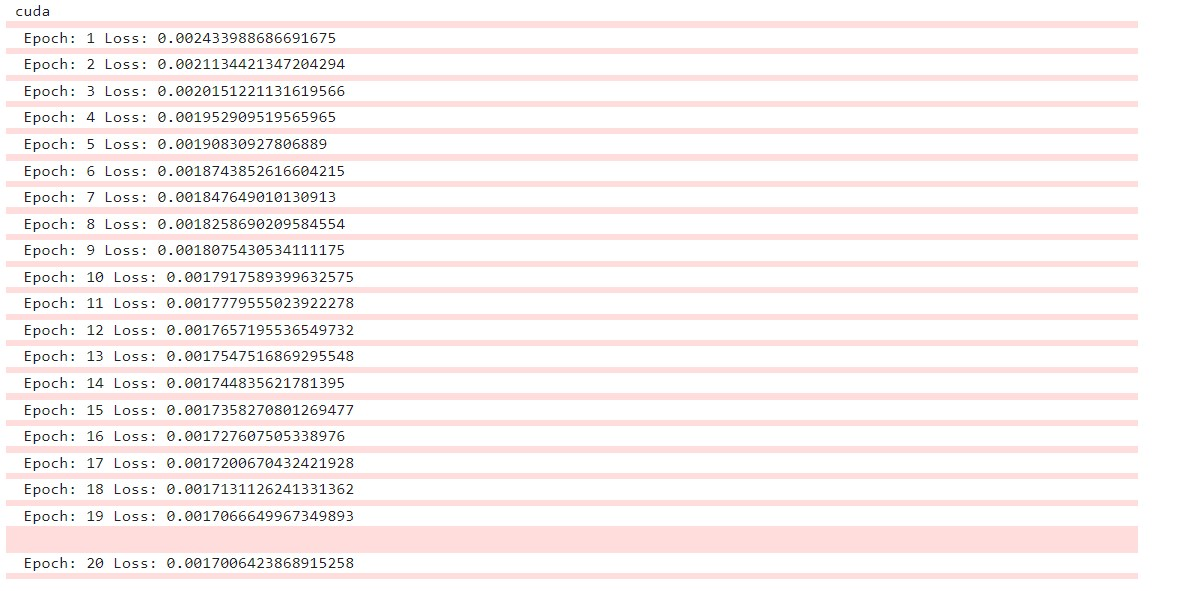

Тут тренував модель з рекурентними шарами

In [31]:
train(vocab, model, hparams, train_text_tokens)

cuda


 Epoch: 1 Loss: 0.0014588037372670257


 Epoch: 2 Loss: 0.0011667612478094282


 Epoch: 3 Loss: 0.0010904315689474928


 Epoch: 4 Loss: 0.0010256663082950437


 Epoch: 5 Loss: 0.0009740036700616613


 Epoch: 6 Loss: 0.000931479561772399


 Epoch: 7 Loss: 0.0008999381861179265


 Epoch: 8 Loss: 0.0008754888731191787


 Epoch: 9 Loss: 0.0008547387934227885


 Epoch: 10 Loss: 0.0008360906527071235


 Epoch: 11 Loss: 0.0008199758817686304


 Epoch: 12 Loss: 0.0008056900050212066


 Epoch: 13 Loss: 0.0007927078615328404


 Epoch: 14 Loss: 0.0007774637464371355


 Epoch: 15 Loss: 0.000766042789619993


 Epoch: 16 Loss: 0.000754127923978383


 Epoch: 17 Loss: 0.0007429643328035628


 Epoch: 18 Loss: 0.0007313599689554513


 Epoch: 19 Loss: 0.0007198998829031152


 Epoch: 20 Loss: 0.0007094550687629539


Гіперпараметри з якими точність була 60%. Це для моделі з лекції

In [ ]:
print(hparams)

{'vocab_size': 82, 'embed_dim': 100, 'context_len': 16, 'hidden_dim': 128, 'learning_rate': 0.001, 'num_epochs': 10, 'batch_size': 64}


In [ ]:
print(hparams)

{'vocab_size': 82, 'embed_dim': 100, 'context_len': 16, 'hidden_dim': 64, 'learning_rate': 0.001, 'num_epochs': 20, 'batch_size': 128}


In [ ]:
print(hparams)

{'vocab_size': 82, 'embed_dim': 64, 'context_len': 16, 'hidden_dim': 64, 'learning_rate': 0.001, 'num_epochs': 20, 'batch_size': 256}


65%

In [ ]:
print(hparams)

{'vocab_size': 82, 'embed_dim': 64, 'context_len': 16, 'hidden_dim': 64, 'learning_rate': 0.001, 'num_epochs': 20, 'batch_size': 128}


In [ ]:
print(hparams)

{'vocab_size': 82, 'embed_dim': 64, 'context_len': 16, 'hidden_dim': 128, 'learning_rate': 0.001, 'num_epochs': 20, 'batch_size': 1024}


Це для LSTM моделі

In [17]:
print(hparams)

{'vocab_size': 82, 'embed_dim': 64, 'context_len': 16, 'hidden_dim': 128, 'learning_rate': 0.001, 'num_epochs': 50, 'batch_size': 1024, 'lstm_hidden_dim': 128}


In [34]:
print(hparams)

{'vocab_size': 82, 'embed_dim': 64, 'context_len': 16, 'hidden_dim': 128, 'learning_rate': 0.01, 'num_epochs': 20, 'batch_size': 2048, 'lstm_hidden_dim': 256}


# Читаємо між рядків

Найкращий результат для моделі з лекції

In [ ]:
import math
import collections
from typing import List, Tuple


# Допоміжна фунція:
def get_letter(w1: str, w2: str) -> str:
    """Повертає літеру, якої відрізняються слова або пробіл для однакових слів.
    """

    letters1 = collections.Counter(w1)
    letters2 = collections.Counter(w2)

    diff = letters1 - letters2
    if len(diff) != 1:
        return " "

    return diff.most_common()[0][0]


def score_text(text: str, model, vocab, metric_type: str, device) -> float:
    """Повертає perplexity або log-probability для тексту."""

    tokens = tokenize(text)

    total_log_prob = 0.0

    for context, target in prepare_data(tokens, model.context_len):
        X = vectorize(context, vocab).to(device)
        target = vectorize([target], vocab)[0].to(device)
        log_probs = model(X)
        target_log_prob = log_probs[0, target]
        total_log_prob += target_log_prob

    if metric_type == 'perplexity':
        return torch.exp(-total_log_prob / len(tokens)).item()
    elif metric_type == 'log-probability':
        return -(total_log_prob / len(tokens)).item()
    else:
        raise ValueError("Invalid metric_type. Choose either 'perplexity' or 'log-probability'.")


# Можете змінювати параметри та весь цей код, якщо потрібно
def solve(model, vocab, test_items) -> Tuple[List[str], str]:
    """Повертає список виправлених слів для кожного з текстів в test_items та
    секретне повідомлення.
    """

    choices = []
    secret = []

    device = next(model.parameters()).device

    for item in test_items:
        scores = []
        for corr in item['corrections']:

            # Підставляємо слово-кандидат в текст
            text = item['text'][:item['error_start']] + corr + item['text'][item['error_end']:]

            # Рахуємо score тексту
            score = score_text(text, model, vocab, 'perplexity', device)
            scores.append(score)

            print(f'{score:.4f} {text}')

        # Сортуємо кандидатів на виправлення за score
        result = sorted(zip(scores, item['corrections']), key=lambda x: x[0])

        # Обираємо найкращу заміну
        best = result[0]
        best_word = best[1]
        choices.append(best_word)

        # Знаходимо чергову літеру повідомлення
        error = item['error']
        letter = get_letter(error, best_word)
        secret.append(letter)

    secret_message = ''.join(secret)

    return choices, secret_message

choices, secret_message = solve(model, vocab, lab.test_items)

lab.evaluate_accuracy(choices)
print("SECRET MESSAGE: ", secret_message)


2.5933 Сховалося, і смеркло в полін.
2.5661 Сховалося, і смеркло в полії.
1.9393 Сховалося, і смеркло в полі.
3.3460 Сховалося, і смеркло в полбі.
2.3067 Сховалося, і смеркло в політ.
2.3299 Сорочечки. А потім в жаті
1.8183 Сорочечки. А потім в хаті
2.6682 Сорочечки. А потім в хатні
1.9833 Сорочечки. А потім в гаті
2.2113 Сорочечки. А потім в хеті
1.9292 Вона той тихий божий став,
1.8993 Вона той тихий божий страв,
2.0770 Вона той тихий божий стан,
2.5571 Вона той тихий божий стад,
1.7535 А тих, що бачать над собою
2.0432 А тих, що бачать над соболю
1.9895 А тих, що бачать над собор
1.9817 А тих, що бачать над побою
2.5368 І ти, як палець той, зосталась
2.2460 І ти, як палець той, посталась
2.4290 І ти, як палець той, остались
2.2283 І ти, як палець той, осталась
3.1622 В своїй крові. Плац великий
2.6789 В своїй крові. Пліч великий
2.2955 В своїй крові. Плач великий
2.7030 В своїй крові. Плат великий
2.5012 Широкий Дніпре, не залий!
2.4639 Широкий Дніпре, не малин!
2.6898 Широкий Дніпр

Найкращий результат для моделі з рекурентними шарами

In [33]:
choices, secret_message = solve(model, vocab, lab.test_items)

lab.evaluate_accuracy(choices)
print("SECRET MESSAGE: ", secret_message)

3.4127 Сховалося, і смеркло в полін.
3.6499 Сховалося, і смеркло в полії.
1.8976 Сховалося, і смеркло в полі.
4.1382 Сховалося, і смеркло в полбі.
2.7963 Сховалося, і смеркло в політ.
2.1354 Сорочечки. А потім в жаті
1.7384 Сорочечки. А потім в хаті
2.2055 Сорочечки. А потім в хатні
2.3261 Сорочечки. А потім в гаті
2.3335 Сорочечки. А потім в хеті
1.7682 Вона той тихий божий став,
2.4549 Вона той тихий божий страв,
2.4325 Вона той тихий божий стан,
2.9723 Вона той тихий божий стад,
1.4537 А тих, що бачать над собою
3.4760 А тих, що бачать над соболю
1.5367 А тих, що бачать над собор
2.4691 А тих, що бачать над побою
2.5992 І ти, як палець той, зосталась
2.7927 І ти, як палець той, посталась
2.2125 І ти, як палець той, остались
2.1028 І ти, як палець той, осталась
3.1767 В своїй крові. Плац великий
3.0736 В своїй крові. Пліч великий
2.2515 В своїй крові. Плач великий
2.9008 В своїй крові. Плат великий
1.8467 Широкий Дніпре, не залий!
3.4066 Широкий Дніпре, не малин!
2.9927 Широкий Дніпр

In [42]:
lab.answer("Василь Стус")

Відповідь правильна ✅
Правильно! 🚀 Заповни тепер цю форму, будь ласка: https://tally.so/r/wkl0zZ


Відправте посилання на цей colab або PDF з ним на пошту oleksii.o.syvokon@lpnu.ua. Дякую!


Для моделі з лекції за допомгою тюнінгу гіперпараметрів вдалось досягнути точності 65%, коли додав LSTM шар, то точність покращилась до 69%.